In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
!pip install scikit-learn
#!pip install datasets

In [3]:
!pip install trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.1/244.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv('Train.csv')

# display datafram
df.iloc[0:]

In [ ]:
rating_stars = df['n_star']
labels = df['label']
comments = df['comment']

ndf = pd.concat([comments, labels, rating_stars], axis = 1)
print(ndf)

In [ ]:
# Extract features from labels and rename the column
features = ndf['label'].str.extractall(r'(?P<Features>[A-Za-z&]+)#(?P<Feedback>Positive|Negative|Neutral)').reset_index(level=1, drop=True)

# Display DataFrame with extracted features
print(features)


In [ ]:
# Pivot the DataFrame
pivot_features = features.pivot_table(index=features.index, columns='Features', values='Feedback', aggfunc=lambda x: ' '.join(x)).fillna('None')

# Reset index
pivot_features = pivot_features.reset_index(drop=True)

# Display the pivot DataFrame
print(pivot_features)

In [ ]:
pivot_features.to_csv('extracted_features.csv', index=False)

In [ ]:
# Merge the pivoted features DataFrame with the original DataFrame
merged_df = pd.concat([ndf, pivot_features], axis=1)

# Display the merged DataFrame
print(merged_df)

In [ ]:
# Drop the 'label' column from the merged DataFrame
merged_df = merged_df.drop('label', axis=1)

# Drop rows with NaN values
merged_df = merged_df.dropna()

# Display the updated DataFrame
print(merged_df)


In [ ]:
merged_df.to_csv('final-train.csv')

In [ ]:
temp = pd.read_csv('final-train.csv')

# display datafram
temp.iloc[0:]

In [ ]:
# Drop all the rows have no feedback
# Filter out rows where feedback is missing
df_filtered = df[~df['label'].str.contains('{OTHERS}')]

# Extract features from labels and rename the column
new_features = df_filtered['label'].str.extractall(r'(?P<Features>[A-Za-z&]+)#(?P<Feedback>Positive|Negative|Neutral)').reset_index(level=1, drop=True)

# Display DataFrame with extracted features
print(new_features)

In [ ]:
# Pivot the DataFrame
new_pivot_features = new_features.pivot_table(index=new_features.index, columns='Features', values='Feedback', aggfunc=lambda x: ' '.join(x)).fillna('None')

# Reset index
new_pivot_features = new_pivot_features.reset_index(drop=True)

# Display the pivot DataFrame
print(new_pivot_features)

In [ ]:
import pandas as pd
import re

def remove_emojis(text):
    # Define a regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    # Remove emojis using the pattern
    return emoji_pattern.sub(r'', text)

def preprocess_data(input_filename, output_filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_filename)

    # Remove emojis from the 'comment' column
    df['comment'] = df['comment'].apply(remove_emojis)

    # Extract columns
    rating_stars = df['n_star']
    labels = df['label']
    comments = df['comment']

    # Concatenate columns into a new DataFrame
    ndf = pd.concat([comments, labels, rating_stars], axis=1)

    # Extract features from labels and rename the column
    features = ndf['label'].str.extractall(r'(?P<Features>[A-Za-z&]+)#(?P<Feedback>Positive|Negative|Neutral)').reset_index(level=1, drop=True)

    # Pivot the DataFrame
    pivot_features = features.pivot_table(index=features.index, columns='Features', values='Feedback', aggfunc=lambda x: ' '.join(x)).fillna('None')

    # Merge the pivoted features DataFrame with the original DataFrame
    merged_df = pd.concat([ndf, pivot_features], axis=1)

    # Drop the 'label' column from the merged DataFrame
    merged_df = merged_df.drop('label', axis=1)

    # Drop rows with NaN values
    merged_df = merged_df.dropna()

    # Save the processed DataFrame to a CSV file
    merged_df.to_csv(output_filename, index=False)

    # Read the saved CSV file and display the DataFrame
    test = pd.read_csv(output_filename)
    print(test)

# Example usage
preprocess_data('Train.csv', 'train.csv')
preprocess_data('Test.csv', 'test.csv')
preprocess_data('Dev.csv', 'dev.csv')

                                                comment  n_star   BATTERY  \
0     Mới mua máy này Tại thegioididong thốt nốt cảm...       5  Positive   
1     Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...       5  Negative   
2     Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...       3      None   
3     Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...       3   Neutral   
4     Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...       5  Positive   
...                                                 ...     ...       ...   
7666  8g. Cái đi đánh là mạng giật giật ko chịu nổi....       1  Negative   
7667  Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...       1      None   
7668  Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...       5  Positive   
7669  Rất tiếc hàng realme ko có ốp lưng ngoài , nên...       3      None   
7670  Mình rất thất vọng khi mua máy này. Bắt wifi c...       1      None   

        CAMERA DESIGN  FEATURES   GENERAL PERFORMANCE     PRICE SCREEN  \
0

In [ ]:
import pandas as pd

def calculate_sentiment_score(row, aspect_columns):
    # Initialize variables
    score = 0
    count_none = 0

    # Define sentiment score mapping
    sentiment_mapping = {'Positive': 0.05, 'Neutral': 0, 'Negative': -0.05}
    naspect = len(aspect_columns)

    # Iterate over aspect columns to calculate sentiment score
    for aspect in aspect_columns:
        feedback = row[aspect]
        if feedback in sentiment_mapping:
            score += sentiment_mapping[feedback]

        if feedback == 'None':
            count_none += 1

        # The quality of feedback increases with its level of detail
        # Calculate the ratio of 'None' value and the number of aspects
        # Adjust the score based on the ratio of 'None' values
        if (count_none / naspect) <= 0.25:
            score += 0.05
        elif (count_none / naspect) >= 0.5:
            score -= 0.05

    # Adjust score based on star ratings
    if row['n_star'] in [1, 2]:
        score -= 0.25
    elif row['n_star'] in [4, 5]:
        score += 0.25

    return score

def normalize_score(sentiment_scores):
    # Define the ranges for each sentiment category
    positive_range = (0, 1)
    neutral_range = (-0.6, 0)
    negative_range = (-1, -0.4)
    max_score = max(sentiment_scores)


    # Normalize the scores based on the defined ranges
    normalized_scores = []
    for score in sentiment_scores:
        if score >= 0:
            normalized_score = positive_range[0] + (positive_range[1] - positive_range[0]) * (score / max_score)
        elif score >= -0.6:
            normalized_score = neutral_range[0] + (neutral_range[1] - neutral_range[0]) * ((score + 0.2) / 0.4)
        else:
            normalized_score = negative_range[0] + (negative_range[1] - negative_range[0]) * ((score + 0.2) / 0.4)
        normalized_scores.append(round(normalized_score, 2))

    return normalized_scores

if __name__ == '__main__':
    filename =  str(input('Input filename: '))
    # Load data
    data = pd.read_csv(filename)
    # Extract feature names from the DataFrame columns
    aspect_columns = [col for col in data.columns if col not in ['index', 'comment']]
    # Calculate sentiment scores for each comment
    sentiment_scores = []
    for _, row in data.iterrows():
        sentiment_scores.append(round(calculate_sentiment_score(row, aspect_columns), 2))

    # Add the normalized sentiment scores to the DataFrame
    data['sentimental-score'] = normalize_score(sentiment_scores)
    lower_filename = filename.lower()
    data.to_csv(f'final-{lower_filename}', index = False)


Input filename: dev.csv


In [ ]:
df = pd.read_csv('final-train.csv')
df.iloc[0:]

,comment,n_star,BATTERY,CAMERA,DESIGN,FEATURES,GENERAL,PERFORMANCE,PRICE,SCREEN,SER&ACC,STORAGE,sentimental-score
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,Positive,Positive,None,Positive,Positive,None,Positive,None,Positive,None,0.79
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,Negative,None,None,None,Positive,None,None,None,None,None,0.25
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,None,None,None,Negative,None,None,None,None,None,None,-0.45
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,Neutral,None,None,Negative,Neutral,None,None,None,None,None,0.12
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,Positive,None,None,None,None,Positive,None,None,Negative,None,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7666,8g. Cái đi đánh là mạng giật giật ko chịu nổi....,1,Negative,None,None,Negative,None,Negative,None,None,None,None,-0.67
7667,Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...,1,None,None,None,Negative,None,Negative,Positive,None,None,None,-0.67
7668,Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...,5,Positive,None,None,None,Positive,Positive,None,None,None,None,0.42
7669,"Rất tiếc hàng realme ko có ốp lưng ngoài , nên...",3,None,None,None,None,Positive,None,Negative,None,Negative,None,-0.37


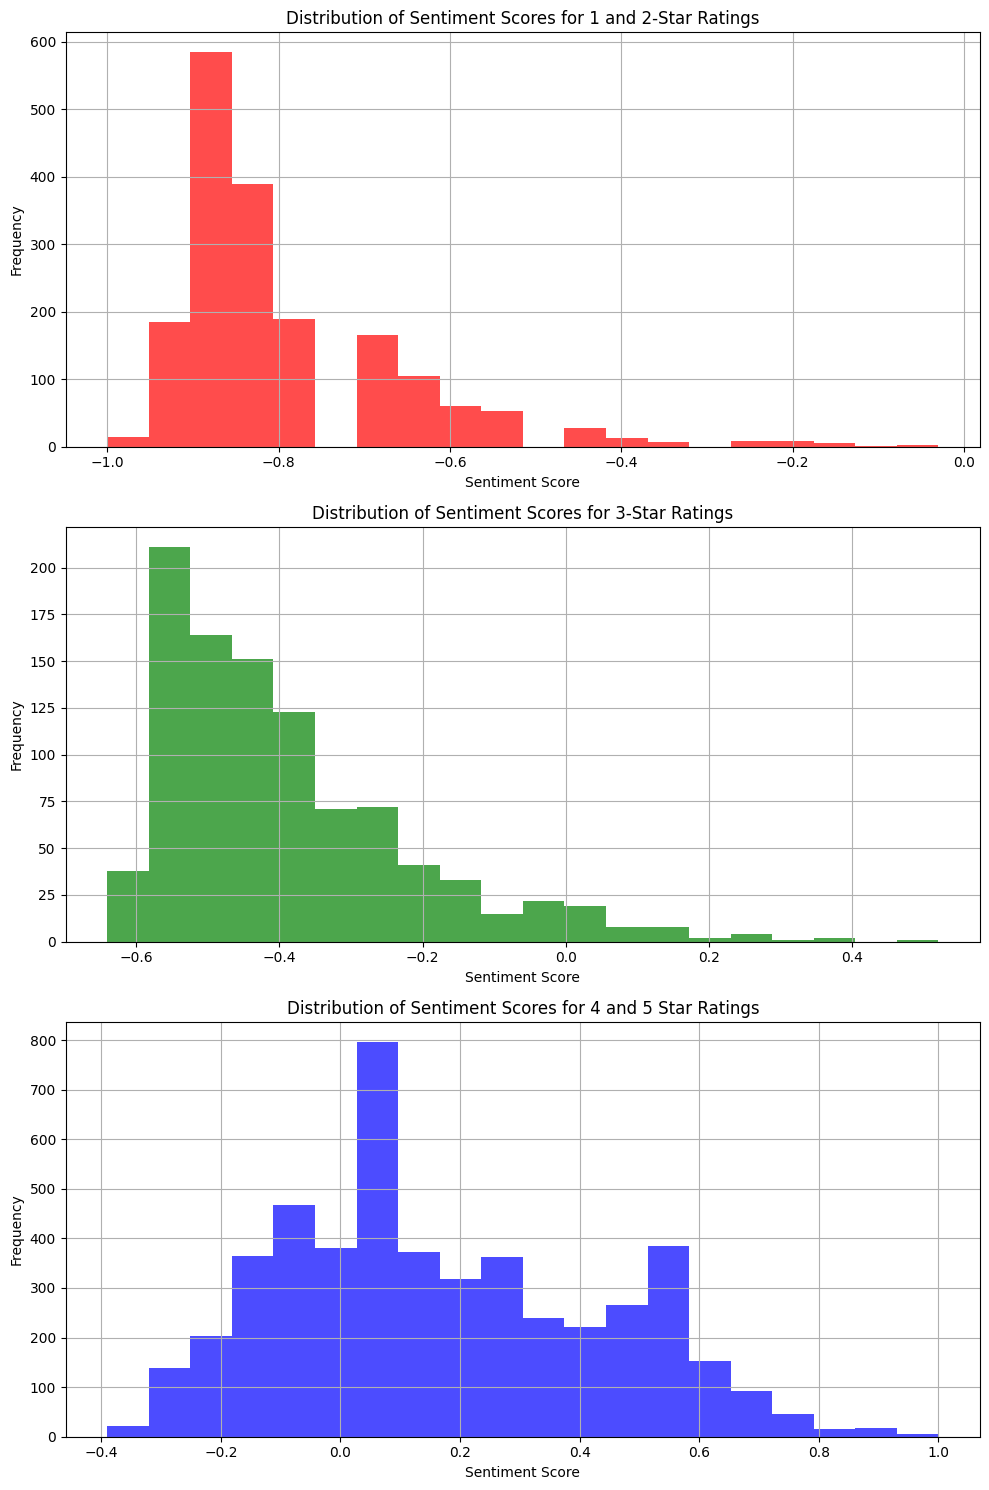

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with three rows and one column
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Filter rows with 'n_stars' equal to 1 or 2
stars_1_2 = df[df['n_star'].isin([1, 2])]
axes[0].hist(stars_1_2['sentimental-score'], bins=20, color='red', alpha=0.7)
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentiment Scores for 1 and 2-Star Ratings')
axes[0].grid(True)

# Filter rows with 'n_stars' equal to 3
stars_3 = df[df['n_star'] == 3]
axes[1].hist(stars_3['sentimental-score'], bins=20, color='green', alpha=0.7)
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentiment Scores for 3-Star Ratings')
axes[1].grid(True)

# Filter rows with 'n_stars' equal to 4 or 5
stars_4_5 = df[df['n_star'].isin([4, 5])]
axes[2].hist(stars_4_5['sentimental-score'], bins=20, color='blue', alpha=0.7)
axes[2].set_xlabel('Sentiment Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Sentiment Scores for 4 and 5 Star Ratings')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


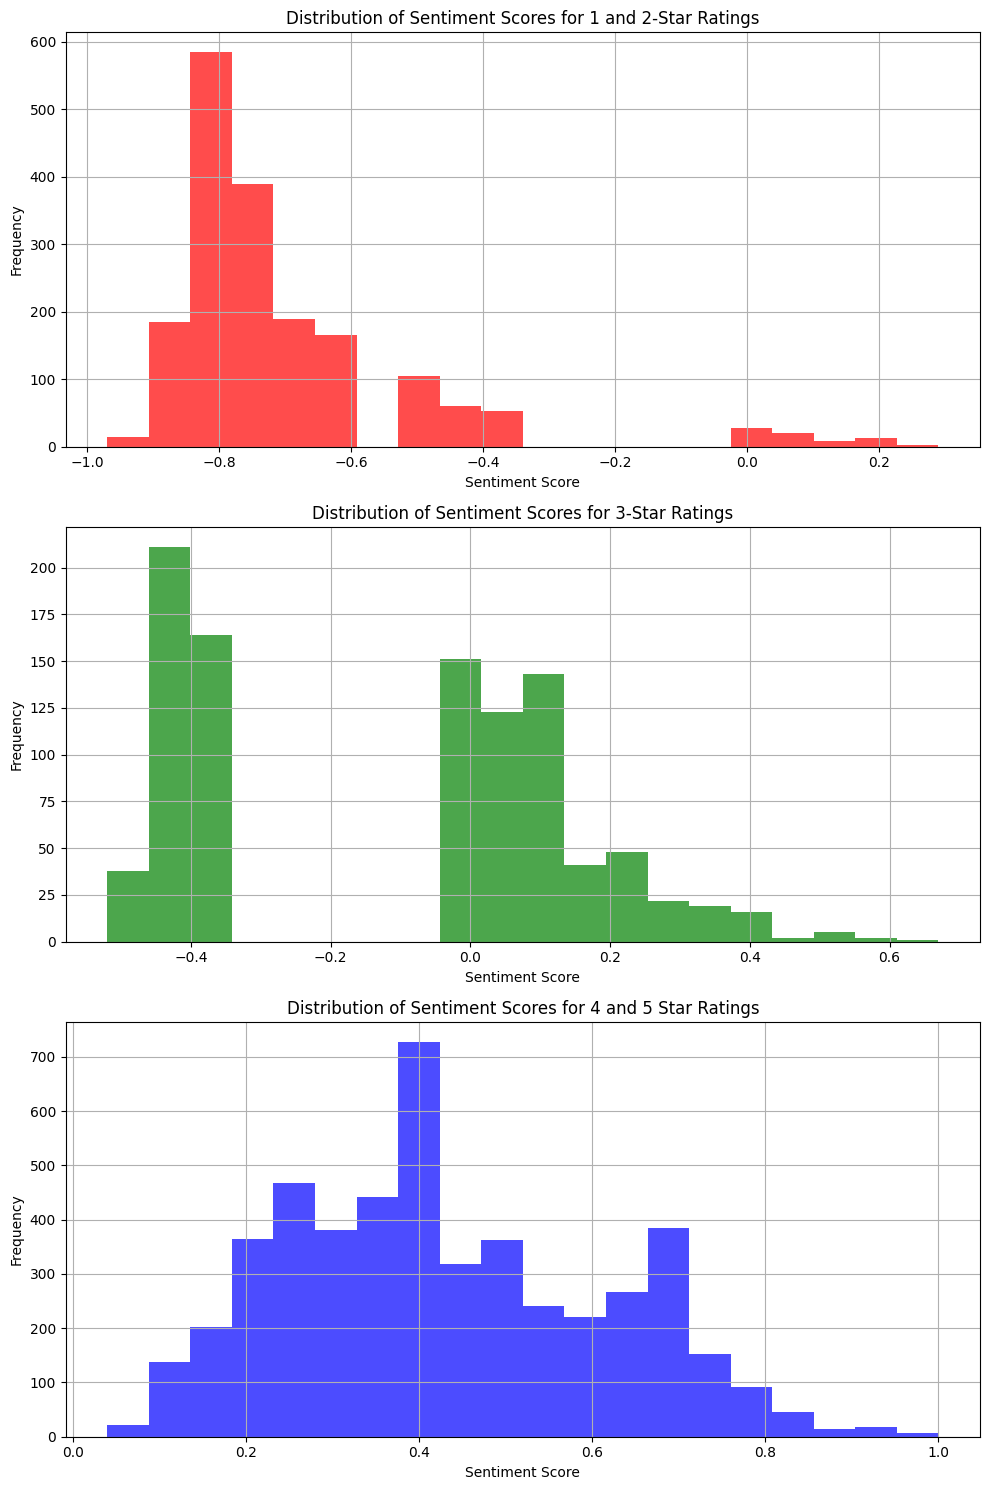

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with three rows and one column
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Filter rows with 'n_stars' equal to 1 or 2
stars_1_2 = df[df['n_star'].isin([1, 2])]
axes[0].hist(stars_1_2['sentimental-score'], bins=20, color='red', alpha=0.7)
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentiment Scores for 1 and 2-Star Ratings')
axes[0].grid(True)

# Filter rows with 'n_stars' equal to 3
stars_3 = df[df['n_star'] == 3]
axes[1].hist(stars_3['sentimental-score'], bins=20, color='green', alpha=0.7)
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentiment Scores for 3-Star Ratings')
axes[1].grid(True)

# Filter rows with 'n_stars' equal to 4 or 5
stars_4_5 = df[df['n_star'].isin([4, 5])]
axes[2].hist(stars_4_5['sentimental-score'], bins=20, color='blue', alpha=0.7)
axes[2].set_xlabel('Sentiment Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Sentiment Scores for 4 and 5 Star Ratings')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

def labeled_data(filename):
    # Read the CSV file into a DataFrame
    data = pd.read_csv(filename)

    # Define ranges for sentiment scores
    positive_range = (0, 1)
    neutral_range = (-0.6, 0)
    negative_range = (-1, -0.4)

    # Initialize an empty list to store labeled data
    labeled_data = []

    # Iterate over each row in the DataFrame
    for _, row in data.iterrows():
        # Extract 'n_star' and 'sentimental-score' values from the row
        n_stars = row['n_star']
        score = row['sentimental-score']

        # Determine label based on star rating and sentiment score
        if n_stars in [4, 5]:
            if score >= positive_range[0] and score <= positive_range[1]:
                label = 'Positive'
            elif score >= negative_range[0] and score <= negative_range[1]:
                label = 'Neutral'
            elif score >= neutral_range[0] and score <= neutral_range[1]:
                label = 'Positive'
        elif n_stars == 3:
            if score >= positive_range[0] and score <= positive_range[1]:
                label = 'Positive'
            elif score >= neutral_range[0] and score <= neutral_range[1]:
                label = 'Neutral'
            elif score >= negative_range[0] and score <= negative_range[1]:
                label = 'Neutral'
        elif n_stars in [1, 2]:
            if score >= positive_range[0] and score <= positive_range[1]:
                label = 'Neutral'
            elif score >= neutral_range[0] and score <= neutral_range[1]:
                label = 'Negative'
            elif score >= negative_range[0] and score <= negative_range[1]:
                label = 'Negative'
        # Append label to labeled_data list
        labeled_data.append(label)

    # Return the labeled data
    return labeled_data

# Ask for filename input from the user
filename = str(input('Input filename: '))

print(labeled_data(filename))
# Call labeled_data function to label the data in the file
df = pd.read_csv(filename)
df['label'] = labeled_data(filename)  # Create new column 'label' with values from labeled_data

df.to_csv(filename, index = False)

Input filename: final-test.csv
['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Neutral', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'P

In [5]:
import pandas as pd
temp = pd.read_csv('final-train.csv')
temp.iloc[0:]

,comment,n_star,BATTERY,CAMERA,DESIGN,FEATURES,GENERAL,PERFORMANCE,PRICE,SCREEN,SER&ACC,STORAGE,sentimental-score,label
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,Positive,Positive,NaN,Positive,Positive,NaN,Positive,NaN,Positive,NaN,0.79,Positive
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,Negative,NaN,NaN,NaN,Positive,NaN,NaN,NaN,NaN,NaN,0.25,Positive
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,NaN,NaN,NaN,Negative,NaN,NaN,NaN,NaN,NaN,NaN,-0.45,Neutral
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,Neutral,NaN,NaN,Negative,Neutral,NaN,NaN,NaN,NaN,NaN,0.12,Positive
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,Positive,NaN,NaN,NaN,NaN,Positive,NaN,NaN,Negative,NaN,0.29,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7666,8g. Cái đi đánh là mạng giật giật ko chịu nổi....,1,Negative,NaN,NaN,Negative,NaN,Negative,NaN,NaN,NaN,NaN,-0.67,Negative
7667,Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...,1,NaN,NaN,NaN,Negative,NaN,Negative,Positive,NaN,NaN,NaN,-0.67,Negative
7668,Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...,5,Positive,NaN,NaN,NaN,Positive,Positive,NaN,NaN,NaN,NaN,0.42,Positive
7669,"Rất tiếc hàng realme ko có ốp lưng ngoài , nên...",3,NaN,NaN,NaN,NaN,Positive,NaN,Negative,NaN,Negative,NaN,-0.37,Neutral


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from datasets import Dataset

def generate_prompt(data_point):
    return f"""
            [INST]
            Analyze the sentiment of the comment in enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "Positive" or "Neutral" or "Negative".[/INST]

            [{data_point["comment"]}] = {data_point["label"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            [INST]
            Analyze the sentiment of the comment in enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "Positive" or "Neutral" or "Negative".[/INST]

            [{data_point["comment"]}] = """.strip()



if __name__ == '__main__':
    train = pd.read_csv('final-train.csv')
    X_train = pd.DataFrame(train.apply(generate_prompt, axis=1), columns=["comment"])

    eval = pd.read_csv("final-dev.csv")
    X_eval = pd.DataFrame(eval.apply(generate_test_prompt, axis=1), columns=["comment"])

    test = pd.read_csv("final-test.csv")
    X_test = pd.DataFrame(test.apply(generate_test_prompt, axis=1), columns=["comment"])
    y_true = test['label']

    train_data = Dataset.from_pandas(X_train)
    eval_data = Dataset.from_pandas(X_eval)

    print(train_data)
    print(eval_data)

Dataset({
    features: ['comment'],
    num_rows: 7671
})
Dataset({
    features: ['comment'],
    num_rows: 1094
})


In [11]:
import os
import warnings
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM,
 AutoTokenizer, BitsAndBytesConfig,
 TrainingArguments,pipeline, logging)
from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb
from trl import SFTTrainer

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

warnings.filterwarnings("ignore")


def load_model():
    model_name = "mistralai/Mistral-7B-Instruct-v0.2"
    compute_dtype = getattr(torch, "float16")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        quantization_config=bnb_config,
    )

    model.config.use_cache = False
    model.config.pretraining_tp = 1

    tokenizer = AutoTokenizer.from_pretrained(model_name,
                                              trust_remote_code=True,
                                              padding_side="left",
                                              add_eos_token=True,
                                            )
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer
model, tokenizer = load_model()


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="steps"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="comment",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=1024,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model")


Map:   0%|          | 0/7671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
25,3.464200,3.391733
50,2.901300,2.240773
75,1.751100,1.459086
100,1.134300,1.313953
125,1.324000,1.259551
150,0.993200,1.256076


In [ ]:
def evaluate(y_true, y_pred):
    labels = ['Positive', 'Neutral', 'Negative']
    mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["comment"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 1,
                        temperature = 0.0,
                       )
        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        answer = result[0]['generated_text'].split("=")[-1].lower()
        if "Positive" in answer:
            y_pred.append("Positive")
        elif "Negative" in answer:
            y_pred.append("Negative")
        elif "Neutral" in answer:
            y_pred.append("Neutral")
    return y_pred

# Little test and evaluate
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)



y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

evaluation = pd.DataFrame({'comment': X_test["comment"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("model-predict.csv", index=False)

100%|██████████| 900/900 [04:05<00:00,  3.67it/s]

Accuracy: 0.848
Accuracy for label 0: 0.947
Accuracy for label 1: 0.760
Accuracy for label 2: 0.837

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       300
           1       0.80      0.76      0.78       300
           2       0.81      0.84      0.82       300

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900


Confusion Matrix:
[[284  14   2]
 [ 14 228  58]
 [  7  42 251]]
